# Cepstral space strain mapping of PTO / DSO

## Table of Contents <a name="toc"/>
[1. Introduction](#intro)<br>
[2. Import packages and data](#load)<br>
[3. Browse 4D STEM data](#browse)<br>
&emsp;[a) Interactive/Dynamic Viewer](#3a)<br>
&emsp;[b) ADF image](#3b)<br>

[4. Exit Wave Power Cepstrum (EWPC)](#EWPC)<br>
&emsp;[a) Perform cepstral transform](#ct)<br>
&emsp;[b) Select EWPC peaks](#peak)<br>
&emsp;[c) Calculate spot maps](#spotmap)<br>

[5. Spot maps](#bspot) - Map of length and angle of the EWPC spots with respect to the center.<br>
[6. Strain maps](#bstrain) - Map of the strain matrix components.<br>
[7. (Optional) PCA Decomposition and Clustering](#PCA) - Segment the region of interest.<br>


## 1. Introduction <a name="intro"/>

This notebook provides you with a 4D browser to quickly visualize 4D-STEM data, as well as some functions to generate virtual images. In the last tutorial, you saw how strain mapping is done using cross correlation with a template. In this notebook, we introduce strain mapping using the Exit Wave Power Cepstral (EWPC) transform method developed at Cornell - [Padgett et al., Ultramicroscopy 214, 112994 (2019)](https://doi.org/10.1016/j.ultramic.2020.112994). For updates to the code, check our [github page](https://github.com/muller-group-cornell/Cepstral_analysis_Python).

Dataset - The sample is a lead titanate (PTO) thin film grown on dysprosium scandate (DSO) substrate. The lattice mismatch prompts the PTO film to form c/a domain structure to minimize the strain energy. Further details about the sample and domain structure can be found at [Langenberg et al., Nano Lett. 2019, 19, 11, 7901–7907](https://doi.org/10.1021/acs.nanolett.9b02991).

This notebook is color-coded. When your input is needed, the markdown cell will indicate the part with <span style="color:orange">this orange color</span>.

[go to top](#toc)
## 2. Import packages and functions <a name="load"/>

In [1]:
# If we are in a Google Colab environment, install packages here.
# If you are running locally, use the install instructions to create an environment with conda
import sys
if 'google.colab' in sys.modules:
  ! pip install numpy matplotlib ipympl ipywidgets --quiet

In [2]:
# Download the dataset and some helper files into the environment
! gdown https://drive.google.com/drive/folders/1fbtHAb4m4WXGjXPb7ufTSPEftwCeWYQM -O tutorial_data --folder -q

/bin/bash: gdown: command not found


In [3]:
# Enable custom matplotlib widgets in colab (not needed on a local Jupyter Lab)
from google.colab import output
output.enable_custom_widget_manager()

In [5]:
#Custom functions used in this script, which are stored in fun.py
from cepstral import * #* means import all functions within the script

#*%matplotlib notebook* mode makes the cells interactive.
#If cells don't seem to be interactive, restart the kernel and run this cell first.
# %matplotlib widget

## Load 4D-STEM Data (.raw format)
Locate the 4D-STEM data you want to look at in a file browser. <span style="color:orange">Copy and paste the directory of the file </span> to assign the variable ***`inputDir`*** <span style="color:orange">and the file name </span> as ***`fname`***. (The path and filename for the sample 4D data is already filled out). <br>

In [1]:
## get the tutorial data

import pyxem as pxm
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import exspy
import scipy
import os
import mplcyberpunk
import matplotlib 
import h5py
import py4DSTEM
from py4Dutils.Added_Functions_For_EELS_Mapping import Set_Wrong_Pixels_to_NaN, Set_Wrong_Pixels_to_Zero, Set_Wrong_Pixels_to_MeanValue
plt.style.use('cyberpunk')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
#need to be set for the interactive GUI
%matplotlib ipympl

In [2]:
inputDir='/masc_shared/ag_volz/Py4dSTEM_tutorial-data/' #directory where the 4D STEM data file is.
fname= 'PTODSO_small_128x130x64x64_float_x64_y64.raw' #name of the 4D-STEM data
saveDir = 'results'#./ means current directory; where this Jupyter notebook is.spotmaps file will be saved here.

data4d=py4DSTEM.io.filereaders.empad.read_empad(inputDir+fname)

The above code directly reads in the 4D STEM data from the raw file output acquired with EMPAD 1. The file name needs to end with the scan size in real space - for this file, 64 steps in x and y directions are indicated by '...x64_y64.raw'. For EMPAD 1, the data for each scan position is saved as 130 x 128 pixels with some metadata. If you need to work with 4D STEM data acquired on other detectors, you will need to change the arguments passed to the function `load_raw_to_dp` in `cepstral.py`.<br>
### Check the dimensions

In [3]:
(rx,ry,sx,sy)=data4d.shape #order: N_x1,N_x2,N_k1,N_k2
(rx,ry,sx,sy)

(64, 64, 128, 128)

[go to top](#toc)
## 3. Browse the 4D-STEM Data <a name="browse"/>
### 3a) Interactive/Dynamic version<a name="3a"/>

Run the following cell. <span style="color:orange">On the real space image (image on the left), click and drag over the region of interest</span>. Then, the average diffraction pattern (DP) from the region inside the shaded red box will be shown on the right. Diffraction space image will ideally show clear diffraction pattern. <span style="color:orange">Draw a box over a diffraction spot</span>. Then, the real space image will show the dark field image corresponding to the selected diffraction spot. Check which region lights up in the real space image. Here, you can see if the corresponding part is tilted or has a different orientation from others, etc. Also, by selecting a diffraction spot, you can distinguish your sample from vacuum/amorphous region easily.

**Goals**: Browse the 4D-STEM Data to (1) check the DP throughout the sample; (2) identify the coordinates of the central beam (coordinates are shown at the bottom right of the figure window); (3) identify diffraction spots that give more information about the sample. <br>

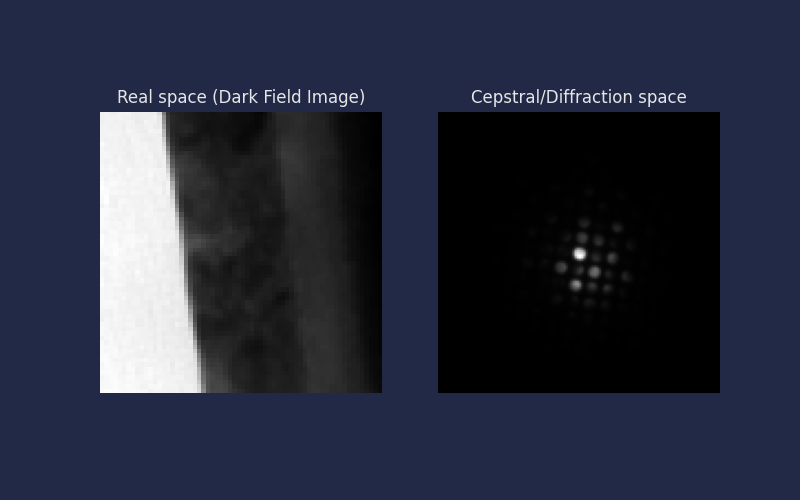

In [6]:
plt.close('all')
guis=browser(data4d)

[go to top](#toc)
### b) Virtual ADF image <a name="3b"/>
**Optional**: Specify the radii (`r0` & `r1`) for the virtual ADF mask. The virtual ADF image generated during this process will be used for selecting the region of interest for the EWPC strain mapping.<br>
**Optional Task** : Change the radii values to form a BF and ABF image.

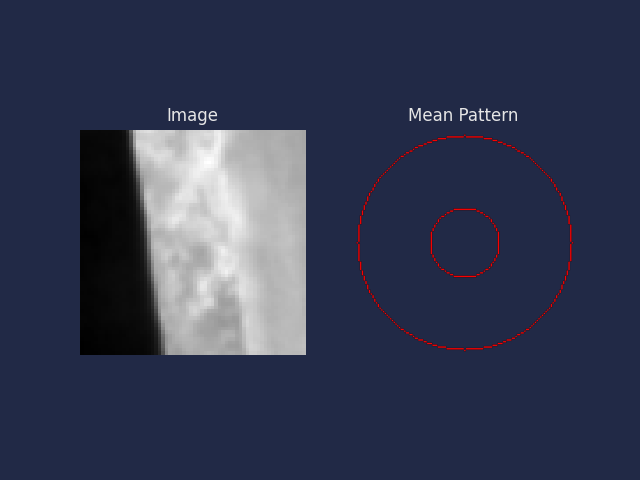

In [26]:
r0=20 #inner radius
r1=60 #outer radius

### display diffraction pattern at real space position
i=30; j=30 #coordinates in real space to get the diffraction image shown on the right
disp_haadf(data4d.data,[r0,r1],i,j)

[go to top](#toc)
## 4. EWPC<a name="EWPC"/>
### 4a) Perform cepstral transform <a name="ct"/>
Theory behind: [Padgett et al., Ultramicroscopy 214, 112994 (2019)](https://doi.org/10.1016/j.ultramic.2020.112994).

In [28]:
ewpc=convert_dp_to_ewpc(data4d.data)

100%|██████████| 64/64 [00:01<00:00, 39.07it/s]


[go to top](#toc)
### 4b) Select EWPC peaks for strain map <a name="peak"/>
Just like you did with the 4D browser,<br>
<span style="color:orange">1)</span> Draw a rectangle in the leftmost window to indicate the area of interest

<span style="color:orange">2)</span> Draw another box around a peak in the cepstral space. Make sure the peak is close to the center of the rectangle.

<span style="color:orange">3)</span> The rightmost window will show a zoomed in image of the box drawn in the middle window. Select just the peak (the brightest spot within the diffraction disk) area, by drawing another box.

<span style="color:orange">4)</span> Click on `Save Results` button to add the region of interest and window location for the strain analysis.

<span style="color:orange">5)</span> Repeat steps 2-4 at least once (you need at least two vectors to calculate strain)

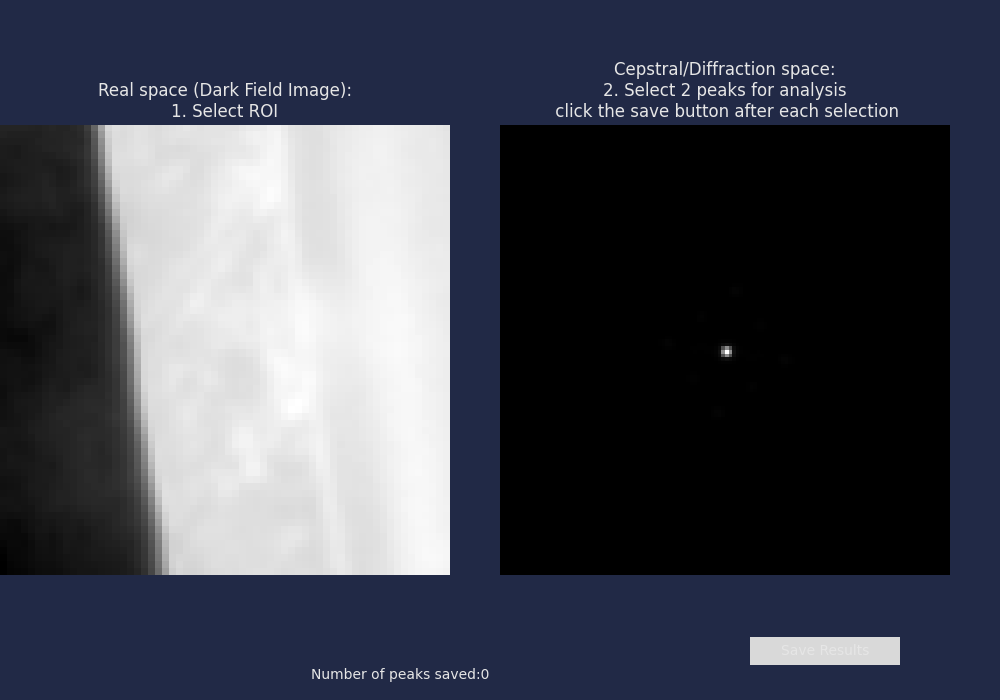

In [32]:
guis,wins,rois=browser_with_peak_selection(ewpc)

[go to top](#toc)
## <span style="color:darkturquoise">Quick reminder about EWPC</span><a name="cp2"/>

The EWPC pattern picks out the periodicity in the diffraction patterns. The different peaks in cepstral space corresponds to different projected interatomic distances in the crystal. So, by tracking the changes in the peak positions of the EWPC spots, we can map out the strain!


# Confirm selection on the dark field cepstral STEM image
Check the region you selected.

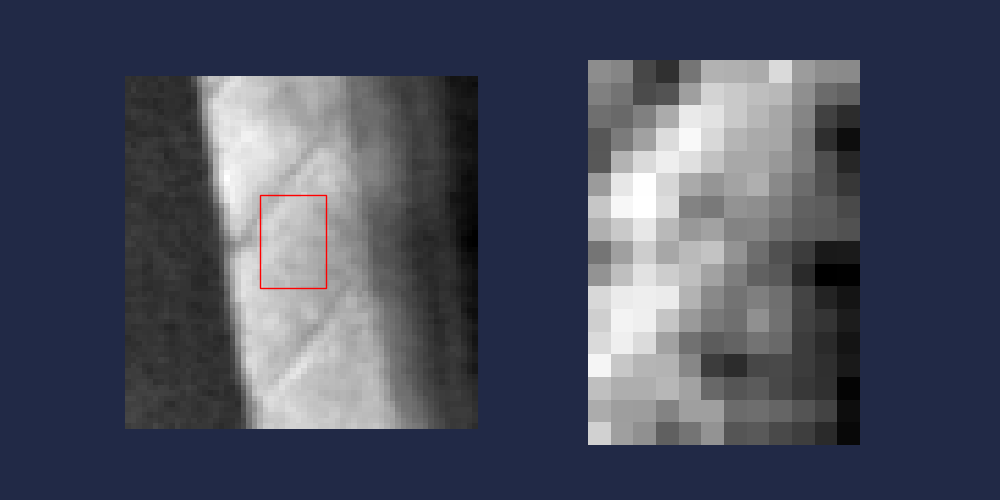

In [33]:
plt.close('all')
#if interactive window didn't work, use the commented out coordinates
roi=rois[0]
wins=np.array(wins)
show_roi(ewpc,roi,wins)

Make sure the selected peaks are shown below within the red boxes.

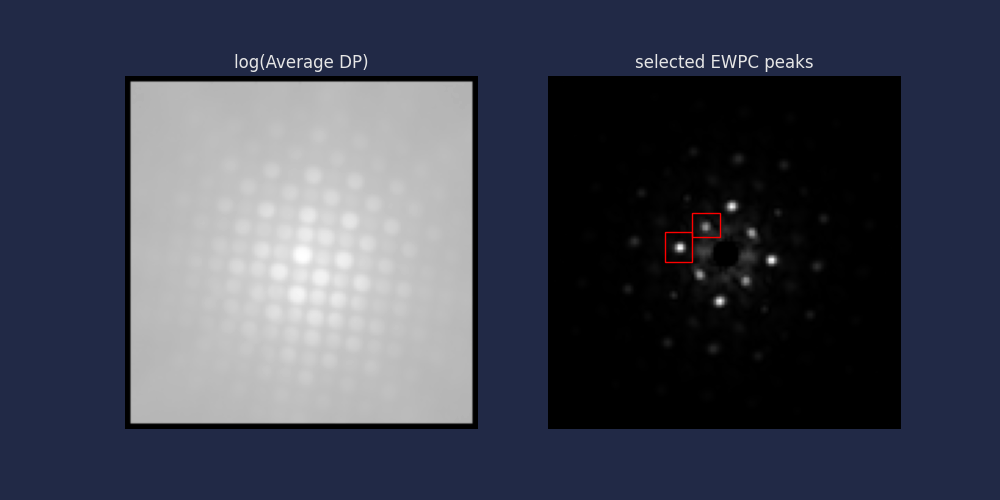

In [34]:
data4d_roi,ewpc_img=show_wins(data4d,wins,roi)

[go to top](#toc)
### 4c) Calculate spot maps <a name="spotmap"/>

Calculate the peak position of the above selected EWPC spots with sub-pixel precision. After the peak position is found, the length and angle of the peak from the center is found.


**Optional**: lower the ***`tol`***, which is tolerance, to get better precision at a cost of increased processing time. ***`tol`*** of 1e-3 to 1e-4 is a good place to start.<br>
Available peak finding ***`method`*** from fastest to slowest : ***`L-BFGS-B`***, ***`Powell`***,***`Nelder-Mead`*** (default),***`TNC`***

In [35]:
spotMaps_upd = get_spotMaps(data4d,wins,tol=1e-3,method='L-BFGS-B',jac='analytical')

100%|██████████| 4096/4096 [00:20<00:00, 195.17it/s]

Time spent: 21s


Save ***`spotMaps`***

In [37]:
import sys,os
os.mkdir(saveDir)

In [39]:
spotMaps_upd['wins']=np.array(wins)
spotMaps_upd['roi']=rois[0]
pickle.dump(spotMaps_upd,open(saveDir+'/spotMaps.dat','wb'))

[go to top](#toc)
## 5. Spot Maps <a name="bspot"/>

Plot of the vector length and angle between the peak positions of the selected EWPC spots and the center of the DP. The vector length is in units of pixels and vector angle in units of radians.

In [40]:
#spotMaps_upd=pickle.load(open(saveDir+'/spotMaps.dat','rb'))  # upload previously saved spot maps
wins=np.array(spotMaps_upd['wins'])
roi=spotMaps_upd['roi']

***`plot_ids`***: <span style="color:orange">Select indices of EWPC peaks</span> from which you would like to get the maps. If you selected only two, enter `[1,2]`<br>
**Optional**: For the following figures, adjust the ***`figureSize`*** if needed.

divide by zero encountered in log


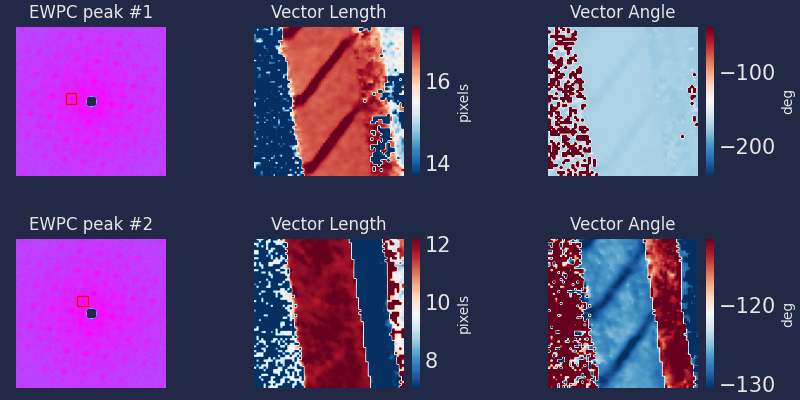

In [41]:
peak_ids=[1,2]

plotSpotMaps(wins[np.array(peak_ids)-1,:],np.log(ewpc_img),
             trim_spotMaps(spotMaps_upd,peak_ids),figureSize=(8,4),plot_ids=peak_ids)

## <span style="color:darkturquoise">CHECKPOINT</span><a name="cp3"/>

PTO has a tetragonal unit cell with its long axis in the direction of ferroelectric polarization. The lattice mismatch with the DSO substrate causes the PTO film to form domains to accomodate the epitaxial strain.

What are the stripes you see here? What does this tell you about the domain structure in PTO - try to characterize the polarization direction in the different domains based on the distance of the EWPC spots from the center.

Also remember that the diffraction/EWPC pattern may be rotated with respect to the real space scan direction. In this case, there is a 90 degree rotation, the EWPC spot that is roughly in the vertical direction corresponds to the out of plane direction, and the EWPC spot that is roughly in the horizontal direction corresponds to the in-plane direction.

[go to top](#toc)
## 6. EWPC strain map <a name="bstrain"/>

In [ ]:
new_spotMaps=trim_spotMaps(spotMaps_upd,peak_ids)

In [ ]:
decomp_order = 1 # choice of left(0)/right(1) polar decomposition of deformation matrix into strain and rotation matrices.
#Use 1 if you want reference EWPC positions as basis vectors
#Use 0 if you want measured EWPC peaks at current pixel position as basis vectors

In [ ]:
image_basis = 0 # If set to 0, uses chosen EWPC spots as basis vectors for strain matrix, set to 1 if you want the image
#coordinates (i.e. the horizontal and vertical directions) as basis vectors; the latter is useful if the best choice of spots
#for peak finding are non-orthogonal

In [ ]:
spotRef = makeRelativeSpotReference_median( new_spotMaps, [0,64,0,64]) #uses the average position of the EWPC spots in the ROI as reference for strain mapping
strainComponents = calculateStrainMap(new_spotMaps, spotRef,latticeCoords=decomp_order,image_basis=image_basis)

The affine transform connecting the position of the EWPC peak position at each pixel to the reference position is calculated, and decoupled into in-plane rotation and lattice parameter change (strain tensor).


The strain tensor components describes the lattice expansion/contraction in Cartesian coordinates: x- ($\epsilon_{11}$), y- ($\epsilon_{22}$) and diagonal xy-direction($\epsilon_{12}$) stretches. $\theta$ is the angle of in-plane lattice rotation.

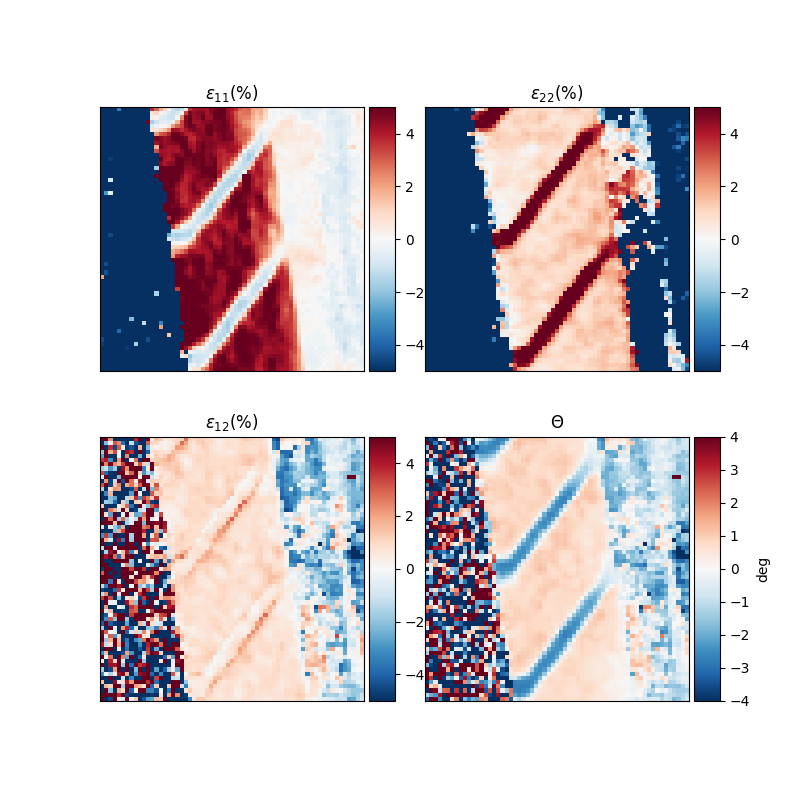

In [ ]:
plotStrainTensor(strainComponents,figureSize=(8,8), vrange_eps=[-5,5], vrange_theta = [-4,4])

Save ***`strainComponents`***

In [ ]:
pickle.dump(strainComponents,open(saveDir+'/strainComponents.dat','wb'))

[go to top](#toc)
## <span style="color:darkturquoise">Optional Tasks (Think about and try at leisure) </span><a name="cp4"/>

1) Now try the strain mapping with a different set of EWPC spots. Explore using different EWPC spots and see how the results compare. This should help develop intuition about which EWPC spots to choose to get optimal results.

What if the EWPC spots you choose are different from the basis vectors you want for your strain tensor?

2) What happens if you choose 2 EWPC spots that are the inverse of each other, i.e spots centered around (x,y) and (-x,-y) pixels? Try to explain why, thinking about how the EWPC pattern is mathematically defined.

3) Notice that in the above strain maps, the vacuum region appears extremely noisy because there are no cepstral peaks there. One can segment out the sample region using k-means clustering + PCA, simple thresholding using intensities, etc. Try out such different segmaentation methods too.

##  Some Tips <a name="cp4"/>
In general, the EWPC spots must be robust over the entire ROI, and should have a good SNR. Noisy spots $\implies$ Noisy strain maps.

Also make sure, the window around the EWPC spot is such that it is: i) big enough to captures any shifts due to changes in lattice spacing ii) small enough that there is no interference from other nearby EWPC spots.


# 7.PCA Decomposition and Clustering <a name="PCA"/>
In many datasets like the above, it is desirable to do a segmentation to select only a portion of the scan area for strain analysis. Here, we use PCA decomposition of the cepstral data and k-means clustering to segment out the sample area from the vacuum region.

In [ ]:
n_components=20 # number of components for PCA decomposition
radii=[5,64] # inner and outer radius of the mask in cepstral space for PCA decomposition

center_beam_mask=create_haadf_mask((ewpc.shape[2],ewpc.shape[3]),radii)
pca,scores=pca_decomposition(ewpc,n_components,center_beam_mask)

flattenning the cepstral signal


100%|██████████| 4096/4096 [00:00<00:00, 4868.65it/s]


normalization of the ewpc pattern


100%|██████████| 12626/12626 [00:02<00:00, 4308.72it/s]


In [ ]:
## save pca model and scores
pickle.dump(pca, open(saveDir+'pca.pkl','wb'))
np.save(saveDir+'/scores.npy',scores)

The different PCA components and a false colored image of their cumulative sum can be visualized by moving the slider to set the cutoff value for the number of PCA components.

One can already see the effectiveness of the PCA decomposition to separate out different features like the vacuum region, substrate and domain patterns in the film.

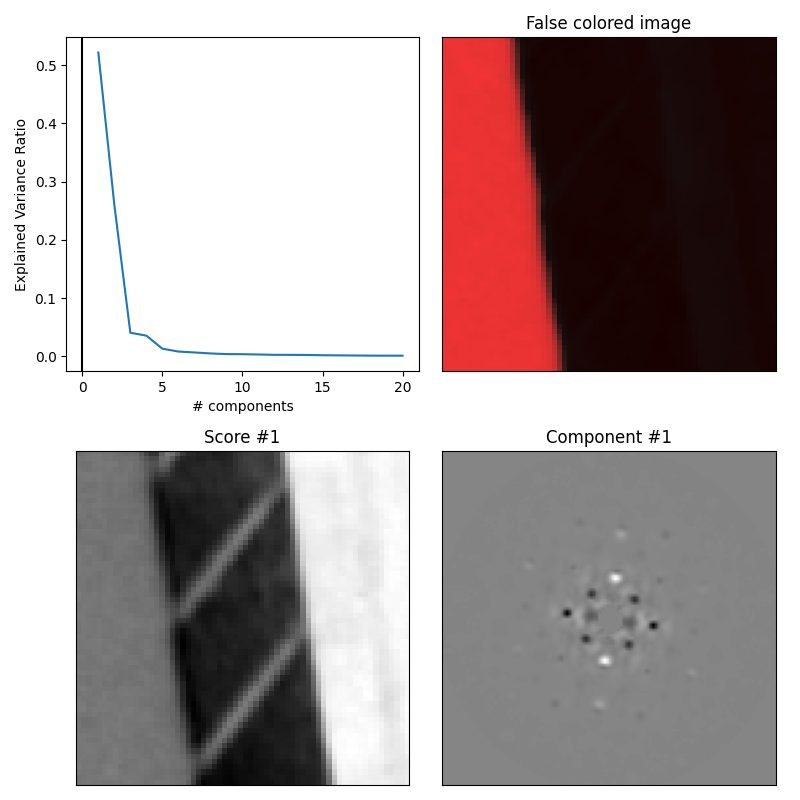

In [ ]:
plt.close('all')
plot_false_color_img(pca,scores,center_beam_mask,cmap='gray')

In [ ]:
clusters_range=[2,5] # minimum and maximum nuber of clusters to segment the data into
cut_off=5 # number of PCA components to be used for clustering

kmeans_dict=perform_kmeans(scores,cut_off,clusters_range)

Performing clustering


  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|███▎      | 1/3 [00:00<00:00,  2.53it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 67%|██████▋   | 2/3 [00:00<00:00,  3.06it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


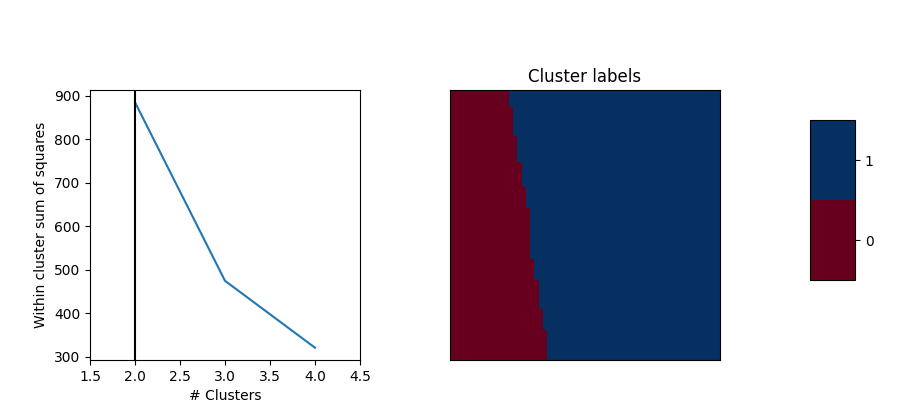

In [ ]:
plot_kmeans_dict(kmeans_dict)

In [ ]:
### choose the number of clusters and select the index of the region of interest

num_clusters = 2
cluster_label = 0

mask=kmeans_dict[num_clusters]['label']==cluster_label

Once we have the mask segmenting out the region of interest, we can track the peak positions of the EWPC spots and produce clean strain maps only for the chosen region.

In [ ]:
spotMaps=get_spotMaps(data4d,wins,valid=mask,method='L-BFGS-B',tol=1e-4,jac='analytical')

100%|██████████| 1195/1195 [00:15<00:00, 77.30it/s]

Time spent: 15s


In [ ]:
spotMaps['wins']=np.array(wins)
spotMaps['roi']=rois[0]
pickle.dump(spotMaps,open(saveDir+'/segmented_spotMaps.dat','wb'))

wins=np.array(spotMaps['wins'])
roi=spotMaps['roi']

<ipython-input-52-20a1fa475d75>:1: RuntimeWarning: divide by zero encountered in log
  plotSpotMaps(wins,np.log(ewpc_img),spotMaps,figureSize=(8,4))


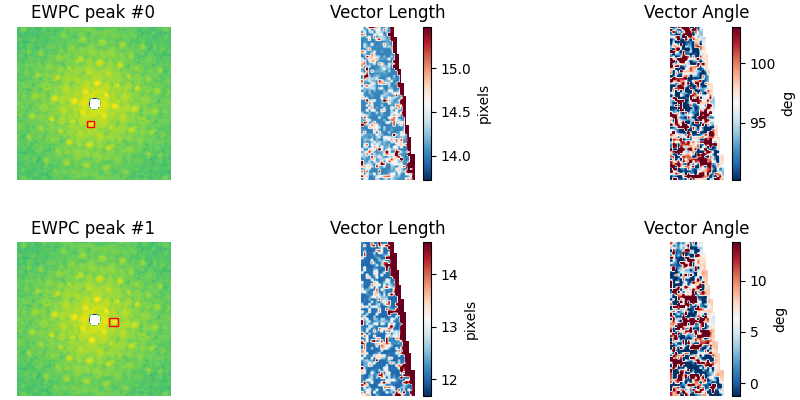

In [ ]:
plotSpotMaps(wins,np.log(ewpc_img),spotMaps,figureSize=(8,4))

In [ ]:
peak_ids=[1,2]
new_spotMaps=trim_spotMaps(spotMaps,peak_ids)

spotRef = makeRelativeSpotReference( new_spotMaps, [0,rx-1,0,ry-1]) #uses the average position of the EWPC spots in the ROI as reference for strain mapping
strainComponents = calculateStrainMap(new_spotMaps, spotRef, latticeCoords=decomp_order)

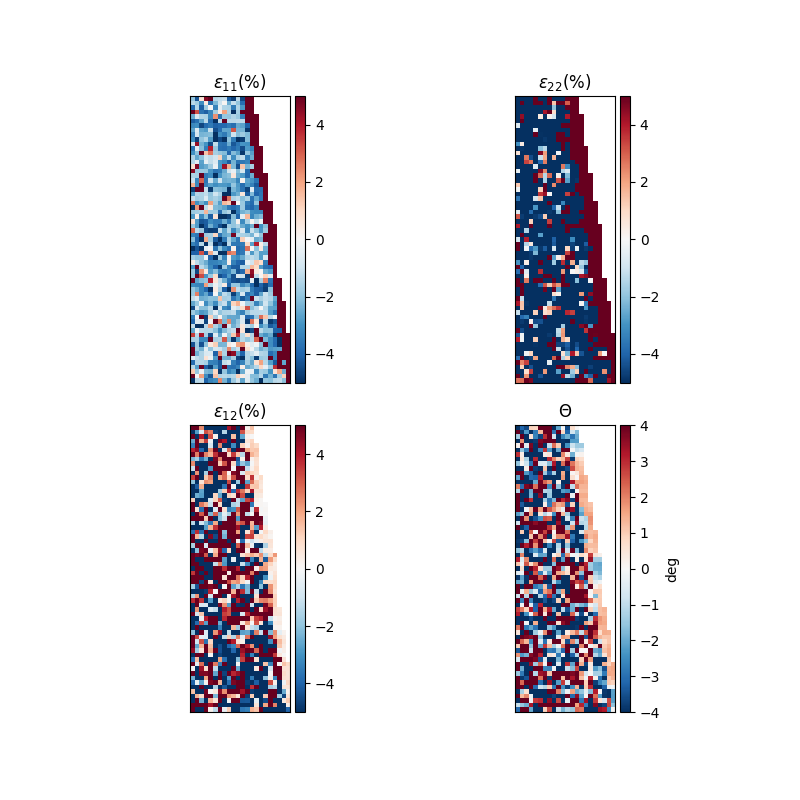

In [ ]:
plotStrainTensor(strainComponents,figureSize=(8,8), vrange_eps = [-5,5], vrange_theta = [-4,4])

[go to top](#toc)

### <span style="color:darkturquoise"> You may change the functions within cepstral.py. If you do so, you can import the updated functions by running the following cell without restarting the kernel. </span>

In [ ]:
import sys, importlib
importlib.reload(sys.modules['cepstral'])
from tutorial_data.cepstral import *